<a href="https://colab.research.google.com/github/King-of-Haskul/HackJMI2-CheemsGamg/blob/master/Pipeline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [118]:
!git clone https://github.com/hashes-jmi/HackJMI2-CheemsGamg

Cloning into 'HackJMI2-CheemsGamg'...
remote: Enumerating objects: 610, done.
remote: Counting objects: 100% (610/610), done.
remote: Compressing objects: 100% (538/538), done.
remote: Total 610 (delta 84), reused 575 (delta 66), pack-reused 0
Receiving objects: 100% (610/610), 53.79 MiB | 27.86 MiB/s, done.
Resolving deltas: 100% (84/84), done.


In [121]:
%cd ..

/content/HackJMI2-CheemsGamg


In [2]:
import os 
import time
import torch 
import matplotlib.pyplot as plt
import numpy as np
import cv2

In [4]:
test_dir = "test"
if not os.path.isdir(test_dir):
  os.makedirs(test_dir)

In [9]:
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode

def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  return filename

In [ ]:
from IPython.display import Image
try:
  filename = take_photo("test/fake.png")
  print('Saved to {}'.format(filename))
  
  # Show the image which was just taken.
  display(Image(filename))
except Exception as err:
  # Errors will be thrown if the user does not have a webcam or if they do not
  # grant the page permission to access it.
  print(str(err))

In [23]:
face_det = torch.hub.load('ultralytics/yolov5', 'custom', path='last.pt')

Using cache found in /root/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2021-10-11 torch 1.9.0+cu111 CUDA:0 (Tesla K80, 11441.1875MB)

Fusing layers... 
Model Summary: 224 layers, 7094365 parameters, 0 gradients
Adding AutoShape... 


In [122]:
img = "79.png"
result = face_det(img)

In [123]:
def enhance_crop(result):
    for i in range(len(result.pred[0])):
        result.pred[0][i][0] -= 25        
        result.pred[0][i][1] -= 20
        result.pred[0][i][2] += 25
        result.pred[0][i][3] += 20
enhance_crop(result)

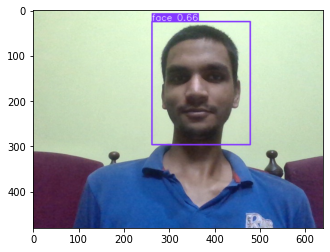

In [124]:
%matplotlib inline
plt.imshow(np.squeeze(result.render()))

In [125]:
def save_crop(result):
    for i in range(len(result.pred[0])):
        x1 = int(result.pred[0][i][0])
        y1 = int(result.pred[0][i][1])
        x2 = int(result.pred[0][i][2])
        y2 = int(result.pred[0][i][3])
    
        img2 = np.squeeze(result.render())
        crop = img2[y1:y2, x1:x2]
        crop = cv2.cvtColor(crop, cv2.COLOR_BGR2RGB)
        crop_resize = cv2.resize(crop, (640, 640)) 
        cv2.imwrite('cropped_images/crop'+str(i+3)+'.png',crop_resize)

save_crop(result)

In [35]:

import requests

def download_file_from_google_drive(id, destination):
    URL = "https://docs.google.com/uc?export=download"

    session = requests.Session()

    response = session.get(URL, params = { 'id' : id }, stream = True)
    token = get_confirm_token(response)

    if token:
        params = { 'id' : id, 'confirm' : token }
        response = session.get(URL, params = params, stream = True)

    save_response_content(response, destination)    

def get_confirm_token(response):
    for key, value in response.cookies.items():
        if key.startswith('download_warning'):
            return value

    return None

def save_response_content(response, destination):
    CHUNK_SIZE = 32768

    with open(destination, "wb") as f:
        for chunk in response.iter_content(CHUNK_SIZE):
            if chunk: # filter out keep-alive new chunks
                f.write(chunk)

file_id = '19dfvGvDfCRYaqxVKypp1fRHwK7XtSjVu'
destination = "./DenseDepth/nyu.h5"
download_file_from_google_drive(file_id, destination)

In [84]:
%cd DenseDepth/

/content/HackJMI2-CheemsGamg/DenseDepth


In [38]:
from keras.models import load_model
from layers import BilinearUpSampling2D


custom_objects = {'BilinearUpSampling2D': BilinearUpSampling2D, 'depth_loss_function': None}
print('Loading model...')
deepdense = load_model('nyu.h5', custom_objects=custom_objects, compile=False)

Loading model...


In [39]:
depth_clf = load_model('../depth_clf_models/depth_clf_2.h5')

In [40]:
from skimage.transform import resize

def to_multichannel(i):
    if i.shape[2] == 3: return i
    i = i[:,:,0]
    return np.stack((i,i,i), axis=2)
def process_output(outputs, is_colormap=True, is_rescale=True):
  plasma = plt.get_cmap('plasma')

  shape = (outputs[0].shape[0], outputs[0].shape[1], 3)
  all_images = []

  for i in range(outputs.shape[0]):    
      if is_colormap:
          rescaled = outputs[i][:,:,0]
          if is_rescale:
              rescaled = rescaled - np.min(rescaled)
              rescaled = rescaled / np.max(rescaled)
          all_images.append(plasma(rescaled)[:,:,:3])
      else:
          all_images.append(to_multichannel(outputs[i]))
  return all_images

In [85]:
% cd ..

/content/HackJMI2-CheemsGamg


In [58]:
!ls

awkwardyears-2.jpg  DenseDepth		    photo.jpg
crop0.png	    DepthClassifier.ipynb   readme.md
crop1.png	    depth_clf_models	    test
cropped_images	    DepthMapsCreator.ipynb  Yolo_Inference.ipynb
data		    last.pt


In [126]:
from DenseDepth.utils import predict, load_images, display_images
from PIL import Image

imgs = os.listdir('cropped_images')
imgs.remove('.ipynb_checkpoints')
for img in imgs:
  image = Image.open(os.path.join('cropped_images', img))
  image = image.resize((640, 640), Image.ANTIALIAS)
  im = np.array(image)
  if im.shape[2] != 3:
    im = im[:,:, :3]
    image = Image.fromarray(im)
  image.save(img)

inputs = load_images(imgs)
outputs = predict(deepdense, inputs)

save_dir = "test"
pro_outputs = process_output(outputs, is_colormap=True, is_rescale=True)
for id, out in enumerate(pro_outputs):
  im = Image.fromarray(np.uint8(out*255))
  im.save(os.path.join(save_dir, str(id)+".png"))

In [127]:
out = np.array(pro_outputs)

In [128]:
pred = depth_clf.predict(out)
pred.shape

(4, 2)

In [129]:
fin = np.argmax(pred, axis=1)

In [130]:
fin

array([1, 1, 0, 1])